In [ ]:
# Creating a route planner for a road network

In [1]:
import os
import warnings
import pandas as pd
from pandas import concat
import numpy as np
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from persiantools.jdatetime import JalaliDate
import datetime
from datetime import datetime, timedelta
import json
import neshan
import polyline
import folium
from IPython.display import HTML, display

In [20]:
# importing neshan API
nmaps = neshan.Client(key='service.PNVDAoZ5IqhevfM0KSCfVlwyXTbjXrbNf7rQvqVe')

In [21]:
# Start finding best route for replanishment of ATMs that are chosen to be replanished

# Read the file which contains the list of chosen ATMs

def distance_function(j):
    BranchesLocations = pd.DataFrame()
    if (j>0):
        Branches = pd.read_excel('./DistanceMatrix.xlsx')
    else:
        Branches = pd.read_excel('./Final.xlsx')

    df = pd.DataFrame(Branches)

    sorted_by_time = df.sort_values('Time')

    # The first ATM in the list is the starting point of the rout to next ATMs

    start_point = pd.DataFrame()
    start_point['Latitude'] = sorted_by_time.Latitude
    start_point['Longitude'] = sorted_by_time.Longitude
    starting_point_tuple = [tuple(i) for i in start_point[0:1].to_numpy()]

    # list of other ATMs 
    other_branches_list = sorted_by_time[1:]
    BranchesLocations['Latitude'] = other_branches_list.Latitude
    BranchesLocations['Longitude'] = other_branches_list.Longitude

    tuples = [tuple(x) for x in BranchesLocations.to_numpy()]       
    
    return(sorted_by_time, other_branches_list, tuples, starting_point_tuple)

In [22]:
# Finding distance matrix from the starting point to all other AtMs in order to fid the nearest

# Calculate distance between pairs of origins and destinations

def calculate_distance_matrix(starting_point_tuple,tuples):
    distance_matrix_result = nmaps.distance_matrix(starting_point_tuple,tuples)
    return(distance_matrix_result)

In [42]:
# Saving the distance matrix from starting point to all other ATMs
# In the complete version of the code this list will be optimized considering the amount of money remained in other ATMs and those ATMs that are going to be empty will be in higher priority

names = list()
name_data_frame = pd.DataFrame()
sorted_by_time, other_branches_list, tuples, starting_point_tuple = distance_function(0)
for j in range(len(sorted_by_time)):
    sorted_by_time, other_branches_list, tuples, starting_point_tuple = distance_function(j)
    distance_matrix_result = calculate_distance_matrix(starting_point_tuple, tuples)
    names.append(sorted_by_time.iloc[0])
    xx =list()
    for i in range(len(distance_matrix_result["rows"][0]["elements"])):
        xx.append(distance_matrix_result["rows"][0]["elements"][i]["duration"]["value"])
    if(len(xx)>1):
        other_branches_list['Time'] = xx
        other_branches_list.to_excel("./DistanceMatrix.xlsx", index = False)

tuples_2 =[]
for x in range(1,len(names)-2):
    tuples_2 = tuples_2 + [(names[x]['Latitude'],names[x]['Longitude'])]


,ردیف,نام ترمینال,کد ترمینال,کد شعبه,Latitude,Longitude,Time
0,21,فروشگاه درسا,386350,950,35.686106,50.964656,168
1,22,مجتمع مسکونی گلسار,365626,950,35.682298,50.964995,286


In [69]:
# After finding the priority of the AMTs the direction will be displayed for the replenishment vehicle

directions_result = nmaps.directions((names[0].Latitude, names[0].Longitude),
                                    (names[-1].Latitude, names[-1].Longitude),
                                    tuples_2)
directions_result
# type(directions_result)
# with open('directions_result.json', 'w') as write_file:
#     json.dump(directions_result, write_file)

In [58]:
overviewPath = polyline.decode(directions_result[0]["overview_polyline"]["points"])
overviewPathGeoJson = polyline.decode(directions_result[0]["overview_polyline"]["points"], geojson=True)
linepath = np.asarray(overviewPathGeoJson)

ave_lat = sum(p[0] for p in overviewPath)/len(overviewPath)
ave_lon = sum(p[1] for p in overviewPath)/len(overviewPath)

# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

#add a markers
for each in tuples_2:  
    folium.Marker(each).add_to(my_map)

#fadd lines
folium.PolyLine(overviewPath, color="red", weight=2.5, opacity=1).add_to(my_map)

# Display map
display(my_map)

# Save map
my_map.save("./gpx_berlin_withmarker.html")

'wygyEcdyxH`@kL_Gbo@ar@}Ik^vb@sEz_@nL|b@_zAhRyPn^~r@tzCc@~xAdJ`Vr`Do\\jc@`OoPhbMug@xwCxWjgD_IjuBrMjbBik@pkDpfAnZ?jpBj^ty@|t@`m@r~AmfAzaAauBvpCdaBbv@~oBkJfm@ceA|~Bf@rlBvi@~uBc@naApk@|fA`Cru@U{@iMrLBh]}IeJI|UuMg@dgA|Ie_@_EoIuBdPvC}Cik@lZkH}ErEpU`FnPgOpXnTv{@`jBeHjwCqZDoYwF~QnE|M|BazCqp@`Hy\\iYcL|I|Dk[gMzD`By`@{FgJ_NbHgp@tk@hLL|Ooa@lhAlSxEJbOoCnViClY_CfR}BdTpKKFfTvWlC'

In [73]:
# Mehdi

tuples_3=[]
sequensec = list()
Branches_01 = pd.read_excel('C:\\Users\\Safarzadeh\\Desktop\\sequence.xlsx')
for j in range(1,len(Branches_01)-1):
    tuples_3 = tuples_3 + [(Branches_01.iloc[j].Latitude,Branches_01.iloc[j].Longitude)]

directions_result_2 = nmaps.directions((Branches_01.iloc[0].Latitude, Branches_01.iloc[0].Longitude),
                                    (Branches_01.iloc[-1].Latitude, Branches_01.iloc[-1].Longitude),
                                    tuples_3)
tuples_3

[(35.682395, 51.013523),
 (35.682293, 51.017239),
 (35.680596, 51.015509),
 (35.678336, 51.012968),
 (35.677266, 51.012835),
 (35.6872, 50.998726),
 (35.688669, 50.992056),
 (35.689603, 50.992558),
 (35.693973, 50.993328),
 (35.695873, 50.995698),
 (35.68506, 50.990273),
 (35.689436, 50.98596),
 (35.689494, 50.983349),
 (35.690095, 50.979559),
 (35.6908, 50.9753),
 (35.691266, 50.972196),
 (35.690066, 50.968919),
 (35.682298, 50.964995),
 (35.686106, 50.964656),
 (35.661671, 50.976896),
 (35.660454, 50.976768),
 (35.671152, 51.019216),
 (35.673712, 51.021396),
 (35.678235, 51.022181)]

In [74]:
# Mehdi

overviewPath = polyline.decode(directions_result_2[0]["overview_polyline"]["points"])
overviewPathGeoJson = polyline.decode(directions_result_2[0]["overview_polyline"]["points"], geojson=True)
linepath = np.asarray(overviewPathGeoJson)

ave_lat = sum(p[0] for p in overviewPath)/len(overviewPath)
ave_lon = sum(p[1] for p in overviewPath)/len(overviewPath)

# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

#add a markers
for each in tuples_3:  
    folium.Marker(each).add_to(my_map)

#fadd lines
folium.PolyLine(overviewPath, color="red", weight=2.5, opacity=1).add_to(my_map)

# Display map
display(my_map)

# Save map
my_map.save("./gpx_berlin_withmarker_2.html")

In [25]:
# BranchesLocations = pd.DataFrame()
# Branches = pd.read_excel('./directions_result.xlsx')
# df = pd.DataFrame(Branches)


# BranchesLocations['Latitude'] = df.Latitude
# BranchesLocations['Longitude'] = df.Longitude

# tuples = [tuple(x) for x in BranchesLocations.to_numpy()]       


In [444]:
# # for distance matrix
# def distance_function(j):
#     BranchesLocations = pd.DataFrame()
#     if (j>0):
#         Branches = pd.read_excel('./DistanceMatrix.xlsx')
#     else:
#         Branches = pd.read_excel('./Final.xlsx')

#     df = pd.DataFrame(Branches)

#     sort_by_time = df.sort_values('Time')

#     start_point = pd.DataFrame()
#     start_point['Latitude'] = sort_by_time.Latitude
#     start_point['Longitude'] = sort_by_time.Longitude
#     starting_point_tuple = [tuple(i) for i in start_point[0:1].to_numpy()]

#     sort_by_time2 = sort_by_time[1:]
#     BranchesLocations['Latitude'] = sort_by_time2.Latitude
#     BranchesLocations['Longitude'] = sort_by_time2.Longitude

#     tuples = [tuple(x) for x in BranchesLocations.to_numpy()]       

    
#     return(sort_by_time, sort_by_time2, tuples, starting_point_tuple)


In [ ]:
# # for directions

# BranchesLocations = pd.DataFrame()

# Branches = pd.read_excel('./BasedOnRemainedRatio.xlsx')

# Branches = Branches.iloc[:, np.r_[2,0,1,3,4,5,6,7,8]]
# Branches
# # Branches.columns = ['Terminal_ID','Branch_Name', 'Branch_Code', 'Latitude', 'Longitude']
# df = pd.DataFrame(Branches)

# BranchesLocations['Latitude'] = Branches.Latitude
# BranchesLocations['Longitude'] = Branches.Longitude

# tuples = [tuple(x) for x in BranchesLocations.to_numpy()]


In [6]:


# nmaps = neshan.Client(key='service.PNVDAoZ5IqhevfM0KSCfVlwyXTbjXrbNf7rQvqVe')

# # Look up an address with reverse geocoding
# # reverse_geocode_result = nmaps.reverse_geocode((40.714224, -73.961452))

# # Request directions via public transit
# now = datetime.now()
# directions_result = nmaps.directions((35.762213, 51.415824),
#                                     tuples[-1],
#                                     tuples[:-1])
# type(directions_result)
# with open('directions_result.json', 'w') as write_file:
#     json.dump(directions_result, write_file)



In [138]:
# # Calculate distance between pairs of origins and destinations
# # distance_matrix_result = nmaps.distance_matrix([(35.762213, 51.415824)],
# #                                                 tuples)
# def calculate_distance_matrix(starting_point_tuple,tuples):
#     distance_matrix_result = nmaps.distance_matrix(starting_point_tuple,tuples)
#     return(distance_matrix_result)

In [28]:
# # distance matrix
# names = list()
# name_data_frame = pd.DataFrame()

# for j in range(len(sort_by_time)):
#     sort_by_time, sort_by_time2, tuples, starting_point_tuple = distance_function(j)
#     distance_matrix_result = calculate_distance_matrix(starting_point_tuple, tuples)
#     names.append(sort_by_time[0:1])
#     xx =list()
#     for i in range(len(distance_matrix_result["rows"][0]["elements"])):
#         xx.append(distance_matrix_result["rows"][0]["elements"][i]["duration"]["value"])
#     if(len(xx)>1):
#         sort_by_time2['Time'] = xx
#         sort_by_time2.to_excel("./DistanceMatrix.xlsx", index = False)

# names
# # name_data_frame = pd.DataFrame(names,columns=['Terminal_ID','Latitude','Longitude', 'نسبت مانده', 'Time' ])
    
# # name_data_frame



709

In [ ]:
# # direction

# len(directions_result[0]["legs"])
# xx =list()
# for i in range(len(directions_result[0]["legs"])):
#     xx.append(directions_result[0]["legs"][i]["duration"]["value"])
# xx
# df['Time'] = xx
# df.to_excel("./directions_result.xlsx")

In [9]:
# m = folium.Map(location=[35.69974, 51.34284])
# m.add_child(folium.ClickForMarker(popup='Waypoint'))
# m


In [16]:
# # Load Roads Network

# url = ('https://github.com/safarzadeh-reza/Sample-Code_Rout-Planning/blob/master/teh_road.zip?raw=true')

# r = io.BytesIO(requests.get(url).content)
# zipfile.ZipFile(r).extractall('data')

# g = nx.read_shp('data/teh_road/teh_road_GCS.shp')

In [17]:
# # Connected subgraphs

# def connected_component_subgraphs(G):
#     for c in nx.connected_components(G):
#         yield G.subgraph(c)

In [18]:
# # Take the largest connected subgraph

# sgs = list(connected_component_subgraphs(g.to_undirected()))
# i = np.argmax([len(sg) for sg in sgs])

# sg = sgs[i]
# len(sg)


2771

In [19]:
# # Define two positions (with the latitude and longitude)
# # in order to find shortest path between them

# #starting point
# pos0 = (35.69974, 51.34284)

# # ending point
# pos1 = (35.75617, 51.51283)

In [21]:
# # If n0 and n1 are connected nodes in the graph,
# # this function returns an array of point
# # coordinates along the road linking these two
# # nodes.

# def get_path(n0, n1):
#     return np.array(json.loads(sg[n0][n1]['Json'])['coordinates'])

In [23]:
# # Computing the distance between any two points in
# # geographical coordinates:

# EARTH_R = 6372.8

# def geocalc(lat0, lon0, lat1, lon1):
#     """Return the distance (in km) between two points
#     in geographical coordinates."""
#     lat0 = np.radians(lat0)
#     lon0 = np.radians(lon0)
#     lat1 = np.radians(lat1)
#     lon1 = np.radians(lon1)
#     dlon = lon0 - lon1
#     y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
#         (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
#          np.cos(lat1) * np.cos(dlon)) ** 2)
#     x = np.sin(lat0) * np.sin(lat1) + \
#         np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
#     c = np.arctan2(y, x)
#     return EARTH_R * c

In [24]:
# # Computing path's length

# def get_path_length(path):
#     return np.sum(geocalc(path[1:, 1], path[1:, 0],
#                           path[:-1, 1], path[:-1, 0]))

In [25]:
# # Update the graph by computing the distance between any two connected nodes.

# for n0, n1 in sg.edges:
#     path = get_path(n0, n1)
#     distance = get_path_length(path)
#     sg.edges[n0, n1]['distance'] = distance


In [26]:
# nodes = np.array(sg.nodes())
# # Get the closest nodes in the graph.
# pos0_i = np.argmin(
#     np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
# pos1_i = np.argmin(
#     np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

In [27]:
# # Compute the shortest path.

# # The path variable contains the list of edges that
# # form the shortest path between our two positions

# path = nx.shortest_path(
#     sg,
#     source=tuple(nodes[pos0_i]),
#     target=tuple(nodes[pos1_i]),
#     weight='distance')
# len(path)


83

In [28]:
# # Get information about the itinerary

# roads = pd.DataFrame(
#     [sg.edges[path[i], path[i + 1]]
#      for i in range(len(path) - 1)],
#     columns=['fclass', 'name',
#              'Shape_Leng', 'distance'])
# roads

,fclass,name,Shape_Leng,distance
0,primary,خیابان آزادی,1799.702030,1.796955
1,primary,خیابان آزادی,78.704872,0.078580
2,primary,خیابان آزادی,630.514990,0.629514
3,primary,خیابان آزادی,13.612999,0.013591
4,primary,خیابان آزادی,688.754039,0.687662
...,...,...,...,...
77,residential,فتحی,257.847141,0.257464
78,primary,هنگام,399.737364,0.400021
79,primary,هنگام,143.917534,0.144076
80,primary,بلوار هنگام,894.926431,0.895412


In [29]:
# # Total length of this itinerary

# roads['distance'].sum()

38.660312506588994

In [134]:
# # Display the itinerary on the map using Smopy (OpenStreetMap image tiles in Python)

# m = smopy.Map(pos0, pos1, z=14, margin=.1)

Lowered zoom level to keep map size reasonable. (z = 12)


In [31]:
# # Return the positions along a path

# # The last point in an edge needs to be close to the first
# # point in the next edge

# def get_full_path(path):
#     p_list = []
#     curp = None
#     for i in range(len(path) - 1):
#         p = get_path(path[i], path[i + 1])
#         if curp is None:
#             curp = p
#         if (np.sum((p[0] - curp) ** 2) >
#                 np.sum((p[-1] - curp) ** 2)):
#             p = p[::-1, :]
#         p_list.append(p)
#         curp = p[-1]
#     return np.vstack(p_list)

In [136]:
# # Convert the path into pixels

# linepath = get_full_path(path)
# x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

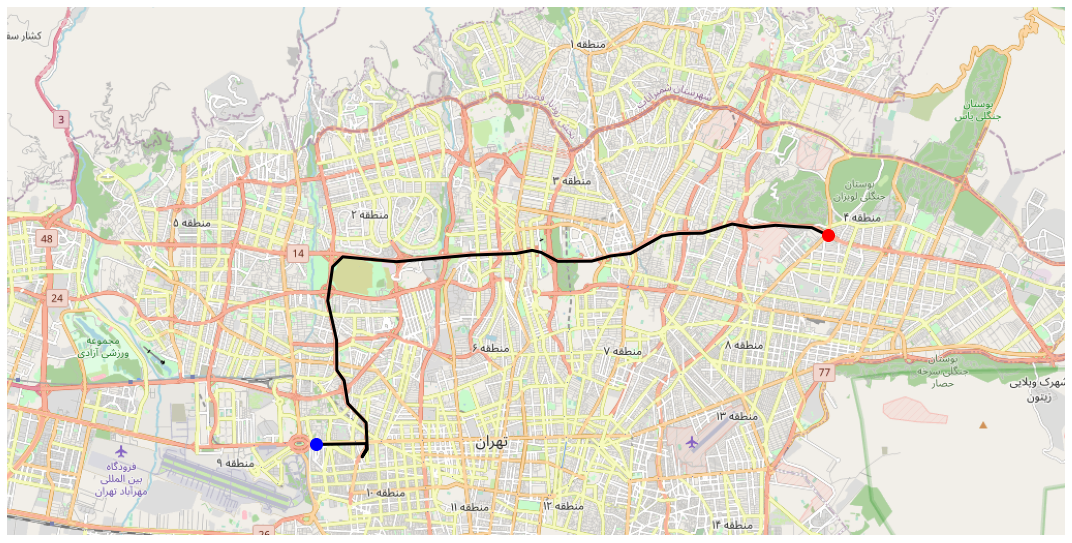

In [137]:
# ax = m.show_mpl(figsize=(15, 15))

# # Plot the itinerary.
# ax.plot(x, y, '-k', lw=3)

# # Mark our two positions.
# ax.plot(x[0], y[0], 'ob', ms=12)
# ax.plot(x[-1], y[-1], 'or', ms=12)